# SMAI ASSIGNMENT 1
### Srujana Vanka - 2020102005

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate 
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import pickle
import time
from sklearn.neighbors import KNeighborsClassifier

# K Nearest Neighbours

## Exploratory dataset visualization
### 2.2.1 - Task 1

In [19]:
# Loading the dataset
data_path = '/home/sruj/Downloads/data.npy'
dataset = np.load(data_path, allow_pickle=True)

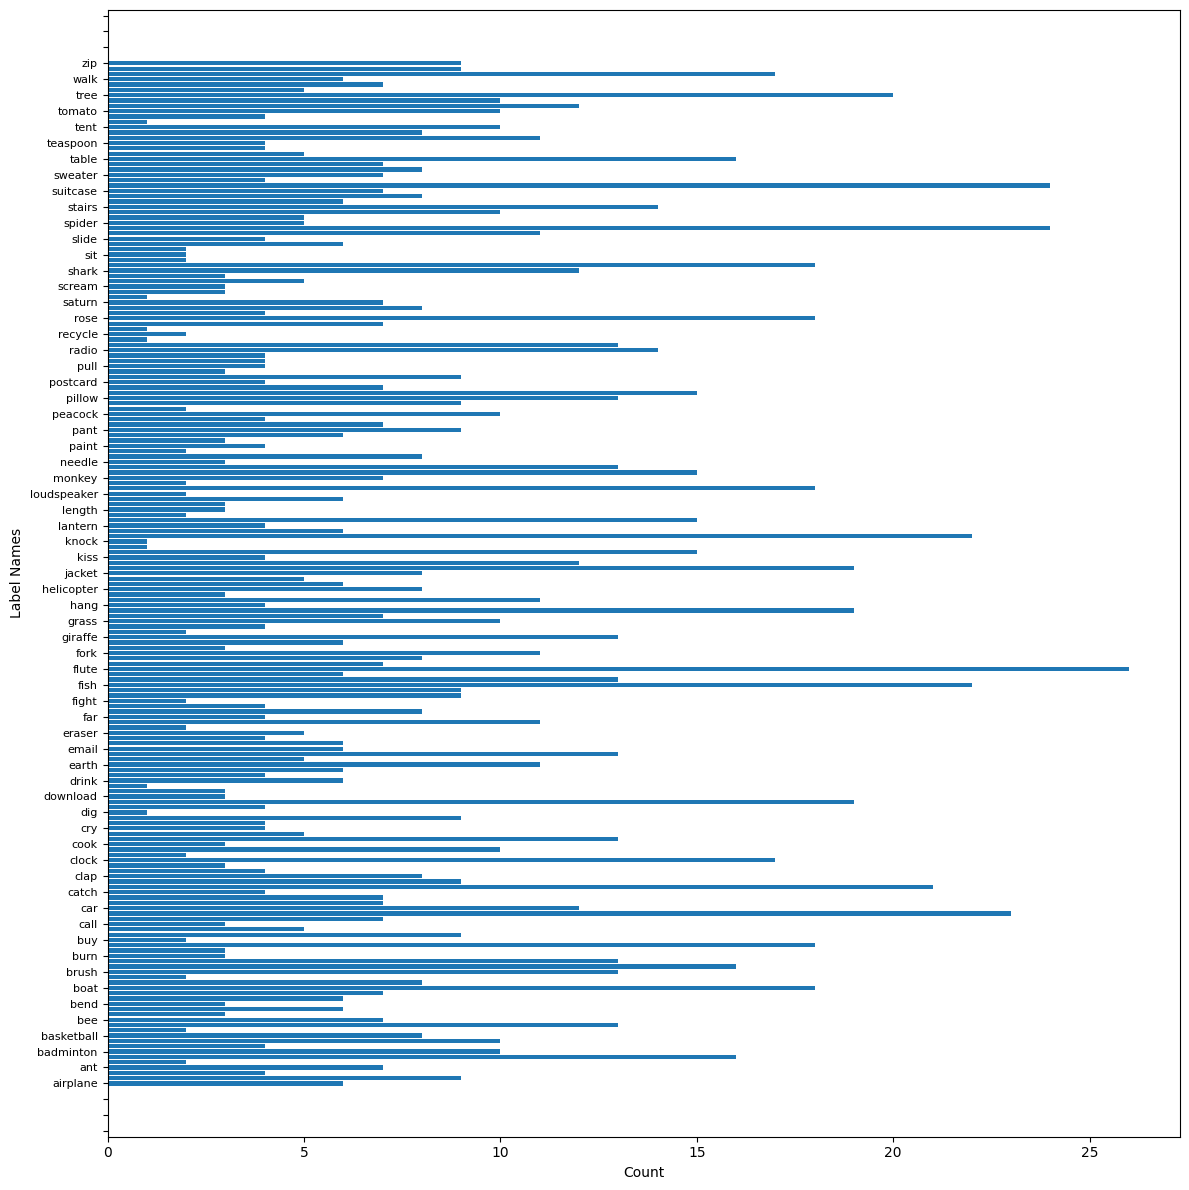

In [3]:
# 4th column = Label name
label_names = dataset[:, 3]

# "ResNet embeddings" and "ViT embeddings," are the feature representations (embeddings) extracted from these models. 
names = ['Game ID', 'ResNet Embeddings', 'VIT Embeddings', 'Label Name', 'Guess']

# Calculate label distribution
# np.unique function to find the unique labels in a dataset, and it also counts how many times each unique label appears. 
unique_labels, label_count = np.unique(label_names, return_counts=True)

# --GPT--
# Bar plot
plt.figure(figsize=(12, 12))
plt.barh(unique_labels, label_count)
plt.xlabel('Count')
plt.ylabel('Label Names')
plt.yticks(fontsize=8)  

# Adjust the number of y-axis labels
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=75))
plt.tight_layout()
plt.show()

In [4]:
# Tabular form 
data_df = pd.DataFrame(dataset, columns=names)

# Calculate label distribution
label_counts_df = pd.DataFrame({'Label Name': unique_labels, 'Count': label_count})

# --GPT--
# Merge label counts with selected data (game id and label name)
selected_data = pd.merge(data_df[['Game ID', 'Label Name']], label_counts_df, on='Label Name')
table = tabulate(selected_data, headers='keys', tablefmt='pretty')
print(table)

+------+--------------------------------------+-------------+-------+
|      |               Game ID                | Label Name  | Count |
+------+--------------------------------------+-------------+-------+
|  0   | 9f894201-9d0d-4f75-853b-595c0c1bd661 |    sleep    |   6   |
|  1   | 6caa8ae5-3a9b-4be0-ba11-083317b6bac2 |    sleep    |   6   |
|  2   | 142e6d23-82c8-4a60-8b66-d5389e796c22 |    sleep    |   6   |
|  3   | 9ce9fabd-b00d-430e-ab8a-ff7ce62c9555 |    sleep    |   6   |
|  4   | b46ab2b8-174d-4472-8163-ea27a086fe2d |    sleep    |   6   |
|  5   | 882287e7-053d-4235-bbfa-dc0056662df1 |    sleep    |   6   |
|  6   | d2b4d879-0345-4df1-a978-eb7f9e8b89f1 |    oven     |   2   |
|  7   | 8362ae32-9469-4087-917d-a650fe584a47 |    oven     |   2   |
|  8   | aaf0c209-f3a7-4c91-9a09-bc1e30400c4c |    chair    |  21   |
|  9   | e59e9998-4d0f-43de-9e12-94e6d26f6bca |    chair    |  21   |
|  10  | 46afb84e-e793-435c-9a6a-a3ce99b4a76e |    chair    |  21   |
|  11  | 9f9c8f58-04

## KNN Implementation
### 2.3.1 - Task 1

In [20]:
# Utility functions - distance metrics
def euclidean(point1, point2):
    if len(point1) != len(point2):
        raise ValueError('Lengths do not match in distance calculation')
    return np.sqrt(np.sum([(x - y) ** 2 for x, y in zip(point1, point2)]))

def manhattan(point1, point2):
    if len(point1) != len(point2):
        raise ValueError('Lengths do not match in distance calculation')
    return np.sum([abs(x - y) for x, y in zip(point1, point2)])

def chebyshev(point1, point2):
    if(len(point1) != len(point2)):
        raise ValueError('Lengths do not match in distance calculation')
    return np.max([abs(x-y) for x, y in zip(point1, point2)])

###  1. Create a class where you can modify and access the encoder type, k, and distance metric of the class

In [21]:
from collections import Counter

class KNNClassifier:
    
    # initializes the object's attributes
    # self is a reference to the object itself
    def __init__(self, k=3, distance_metric='euclidean', encoding_type='resnet'):
        self.k = k
        self.distance_metric = distance_metric
        self.encoding_type = encoding_type

    def _get_distance(self, point1, point2):
        if self.distance_metric == 'euclidean':
            return euclidean(point1, point2)
        elif self.distance_metric == 'manhattan':
            return manhattan(point1, point2)
        elif self.distance_metric == 'chebyshev':
            return chebyshev(point1, point2)
        else:
            raise ValueError("Invalid distance metric")

    # Store training data
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def prediction(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = [self._get_distance(test_point, train_point) for train_point in self.X_train]
            sorted_indices = np.argsort(distances)
            k_nearest_indices = sorted_indices[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]

            # Count the occurrences of each label in the k nearest neighbors and select the most common label
            label_counter = Counter(k_nearest_labels)
            most_common_label = label_counter.most_common(1)[0][0]
            predictions.append(most_common_label)
        return predictions


### 2. Return the inference (prediction) when given the above parameters (encoder type, k, and distance metric).

In [22]:
# Using either ResNet or VIT embeddings based on the encoding type
encoding_type = 'resnet'  
# encoding_type = 'vit'

if encoding_type == 'resnet':
    embeddings_column_index = 1
elif encoding_type == 'vit':
    embeddings_column_index = 2

# Extract embeddings based on the selected encoding type
embeddings = dataset[:, embeddings_column_index]

# Load a batch of data points (embeddings) for prediction
data_batch = embeddings[:15]  

# Split data into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(embeddings, label_names, test_size=0.3)

knn = KNNClassifier(k=5, distance_metric='euclidean', encoding_type=encoding_type)

# Fit the classifier on training data
knn.fit(X_train, y_train)

# Save the trained model using pickle
with open('trained_knn_model.pkl', 'wb') as trained_model:
    pickle.dump(knn, trained_model)

# Use the KNN classifier to predict labels for the batch of data points
predicted_labels = knn.prediction(data_batch)
print("Predicted Labels:", predicted_labels)

Predicted Labels: ['sleep', 'oven', 'table', 'igloo', 'fish', 'rain', 'radio', 'flute', 'dragonfly', 'table', 'pillow', 'notebook', 'candle', 'sweater', 'love']


### 3. Return the validation f-1 score, accuracy, precision, and recall after splitting the provided dataset into train and val subsets.

In [11]:
# Create a list to hold the results for ResNet and VIT embeddings
results = []

for encoding_type in ['ResNet', 'VIT']:
    # Use either ResNet or VIT embeddings based on the encoding type
    embeddings_column_index = 1 if encoding_type == 'ResNet' else 2

    # Extract embeddings 
    embeddings = dataset[:, embeddings_column_index]
    
    # Split data into training and validation subsets
    X_train, X_val, y_train, y_val = train_test_split(embeddings, label_names, test_size=0.3)

    # Create KNN classifier instance
    knn = KNNClassifier(k=5, distance_metric='euclidean', encoding_type=encoding_type)

    # Fit the classifier on training data
    knn.fit(X_train, y_train)

    # Predict on validation data
    y_pred = knn.prediction(X_val)

    # Evaluate the classifier's performance
    f1 = round(f1_score(y_val, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_val, y_pred), 4)
    precision = round(precision_score(y_val, y_pred, average='weighted', zero_division=1), 4) # zero_division parameter - precision for a class will be set to 0 when there are no predicted samples for that class, and it won't result in a warning. 
    recall = round(recall_score(y_val, y_pred, average='weighted', zero_division=1), 4)

    # Append results to the list
    results.append((encoding_type, accuracy, precision, recall, f1))

# Print the results table
print("Distance Metric = Euclidean")
headers = ['Encoding Type', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
print(tabulate(results, headers=headers, tablefmt='pretty'))


Distance Metric = Euclidean
+---------------+----------+-----------+--------+----------+
| Encoding Type | Accuracy | Precision | Recall | F1 Score |
+---------------+----------+-----------+--------+----------+
|    ResNet     |  0.1778  |  0.4322   | 0.1778 |  0.157   |
|      VIT      |  0.2533  |  0.4832   | 0.2533 |  0.2338  |
+---------------+----------+-----------+--------+----------+


## Hyperparameter Tuning
### 2.4.1 - Task 2

### 1. Find the best (k, encoder, distance metric) triplet for validation accuracy

In [12]:
# Initialising variables 
best_accuracy = 0.0
best_triplet = None
triplets = []

# --GPT--
for k in [3, 5, 7, 9]:  # Vary k values
    for encoder_type in ['ResNet', 'VIT']:  # Both encoders
        for distance_metric in ['euclidean', 'manhattan', 'chebyshev']:  # Distance metrics
            knn = KNNClassifier(k=k, distance_metric=distance_metric, encoding_type=encoder_type)
            knn.fit(X_train, y_train)
            val_predictions = knn.prediction(X_val)
            accuracy = round(accuracy_score(y_val, val_predictions),4)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_triplet = (k, encoder_type, distance_metric)
            
            triplets.append((k, encoder_type, distance_metric, accuracy))

# Print the best triplet and its accuracy
print(f"Best Triplet giving highest accuracy: k={best_triplet[0]}, Encoder Type={best_triplet[1]}, Distance Metric={best_triplet[2]}, Accuracy={best_accuracy}")

Best Triplet giving highest accuracy: k=9, Encoder Type=ResNet, Distance Metric=euclidean, Accuracy=0.2711


### 2. Print an Ordered rank list of top 20 such triplets.

In [13]:
# Sorting the triplets
sorted_triplets = sorted(triplets, key=lambda x: x[3], reverse=True)

top_triplets = []

# Append the top 20 unique triplets to the list
for i, triplet in enumerate(sorted_triplets[:20]):
    top_triplets.append([i+1, triplet[0], triplet[1], triplet[2], triplet[3]])

# Print in a table
print("Top 20 Triplets:")
headers = ['#', 'k', 'Encoder', 'Distance', 'Accuracy']
print(tabulate(top_triplets, headers=headers, tablefmt='pretty'))

Top 20 Triplets:
+----+---+---------+-----------+----------+
| #  | k | Encoder | Distance  | Accuracy |
+----+---+---------+-----------+----------+
| 1  | 9 | ResNet  | euclidean |  0.2711  |
| 2  | 9 |   VIT   | euclidean |  0.2711  |
| 3  | 7 | ResNet  | manhattan |  0.2689  |
| 4  | 7 |   VIT   | manhattan |  0.2689  |
| 5  | 9 | ResNet  | manhattan |  0.2644  |
| 6  | 9 |   VIT   | manhattan |  0.2644  |
| 7  | 7 | ResNet  | euclidean |  0.2578  |
| 8  | 7 |   VIT   | euclidean |  0.2578  |
| 9  | 5 | ResNet  | euclidean |  0.2533  |
| 10 | 5 | ResNet  | manhattan |  0.2533  |
| 11 | 5 |   VIT   | euclidean |  0.2533  |
| 12 | 5 |   VIT   | manhattan |  0.2533  |
| 13 | 3 | ResNet  | euclidean |  0.2467  |
| 14 | 3 |   VIT   | euclidean |  0.2467  |
| 15 | 3 | ResNet  | manhattan |   0.24   |
| 16 | 3 |   VIT   | manhattan |   0.24   |
| 17 | 3 | ResNet  | chebyshev |  0.1378  |
| 18 | 3 |   VIT   | chebyshev |  0.1378  |
| 19 | 5 | ResNet  | chebyshev |  0.1311  |
| 20 | 5 |   VI

### 3. Plot k vs accuracy given a choice(yours) of any given distance, encoder pair (with a constant data split).

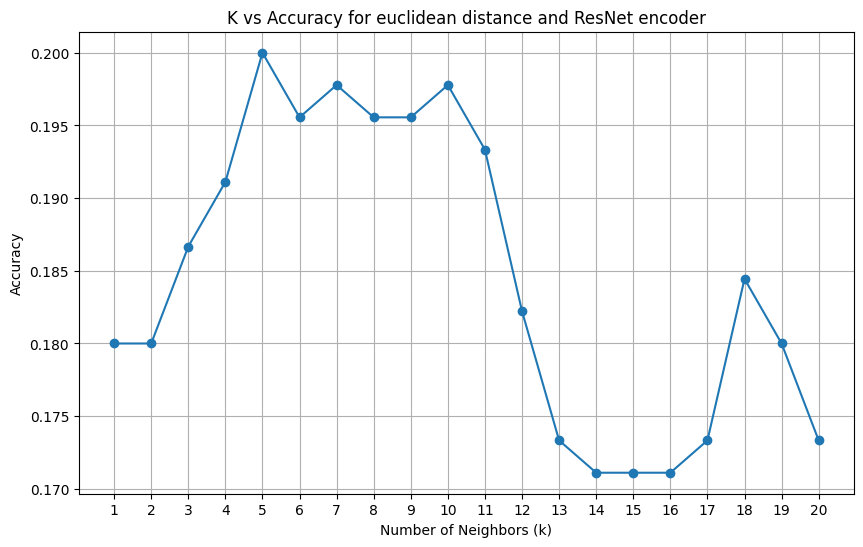

In [11]:
# Constant distance metric and encoder pair
chosen_distance_metric = 'euclidean'
chosen_encoder = 'ResNet'
embeddings = dataset[:, 1]  # ResNet Embeddings (column index 1)

X_train, X_val, y_train, y_val = train_test_split(embeddings, label_names, test_size=0.3)

k_value = []
accuracy_value = []

# --GPT--
# k from 1 to 20
for k in range(1, 21): 
    knn = KNNClassifier(k=k, distance_metric=chosen_distance_metric, encoding_type=chosen_encoder)
    knn.fit(X_train, y_train)
    val_predictions = knn.prediction(X_val)
    accuracy = accuracy_score(y_val, val_predictions)
    k_value.append(k)
    accuracy_value.append(accuracy)

# Plot k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_value, accuracy_value, marker='o')
plt.title(f'K vs Accuracy for {chosen_distance_metric} distance and {chosen_encoder} encoder')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_value)
plt.grid(True)
plt.savefig('k_vs_accuracy_plot.png')  
plt.show()

## Optimization

### Is it possible to improve the execution time of the program? Hint: Use Vectorization.

In [23]:
# Optimised KNN
class OptimizedKNNClassifier:
    def __init__(self, k=3, distance_metric='euclidean', encoding_type='resnet'):
        self.k = k
        self.distance_metric = distance_metric
        self.encoding_type = encoding_type

    def getDistance(self, point1, point2):
        if self.distance_metric == 'euclidean':
            return euclidean(point1, point2)
        elif self.distance_metric == 'manhattan':
            return manhattan(point1, point2)
        elif self.distance_metric == 'chebyshev':
            return chebyshev(point1, point2)
        else:
            raise ValueError("Invalid distance metric")

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    # --GTP--
    def prediction(self, X_test):
        predictions = []
        for test_point in X_test:
            test_distances = np.array([self.getDistance(test_point, x) for x in self.X_train])
            k_nearest_indices = np.argpartition(test_distances, self.k)[:self.k]
            k_nearest_labels = self.y_train[k_nearest_indices]
            most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common_label)
        return predictions

**1. Distance Computation**:

OptimizedKNNClassifier: Computing distances using NumPy array operations for all test points and training points simultaneously, resulting in more efficient calculations.

KNNClassifier: Computing distances using a loop that iterates over each training point for each test point.

**2. Neighbor Selection**:

OptimizedKNNClassifier: Using np.argpartition to quickly find the indices of the k nearest neighbors. This is likely more efficient than sorting the distances as in the original KNN.

KNNClassifier: Sorts the distances and selects the k nearest neighbors based on the sorted indices.

In [8]:
# Triplet with the least inference time
least_inference_time = float('inf')
best_triplet = None
triplets = []

for k in [3, 5, 7, 9]:  # Vary k values
    for encoder_type in ['ResNet', 'VIT']:  # Both encoders
        for distance_metric in ['euclidean', 'manhattan', 'chebyshev']:  # Distance metrics
            op_knn = OptimizedKNNClassifier(k=k, distance_metric=distance_metric, encoding_type=encoder_type)
            
            start_time = time.time()
            op_knn.fit(X_train, y_train)
            _ = op_knn.prediction(X_val)
            end_time = time.time()
            inference_time = round(end_time - start_time, 4)
            triplets.append((k, encoder_type, distance_metric, inference_time))
            if inference_time < least_inference_time:
                least_inference_time = inference_time
                best_triplet = (k, encoder_type, distance_metric)

# Print the best triplet and its inference time
print(f"Best Triplet for Least Inference Time: k={best_triplet[0]}, Encoder Type={best_triplet[1]}, Distance Metric={best_triplet[2]}, Inference Time={least_inference_time}")


Best Triplet for Least Inference Time: k=3, Encoder Type=VIT, Distance Metric=chebyshev, Inference Time=5.0628


### Plot inference time for initial KNN model, best KNN model, most optimized KNN model, and the default sklearn KNN model.

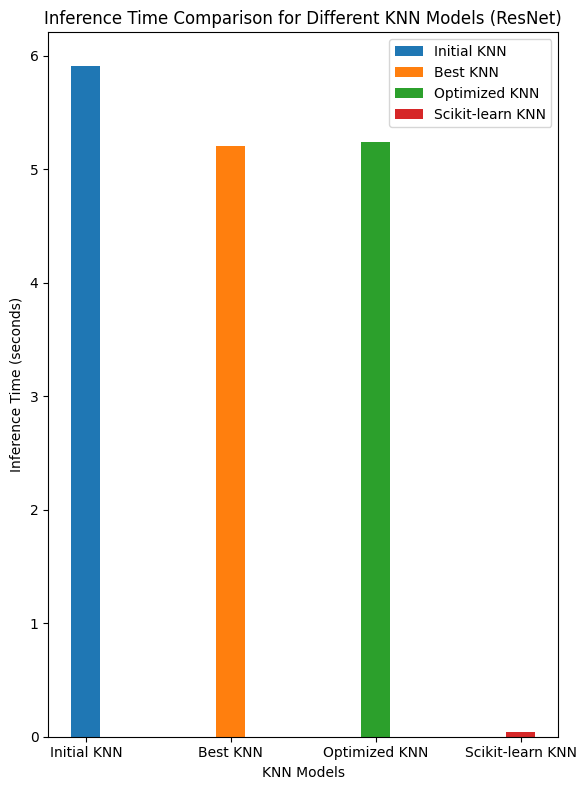

In [14]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Initialize variables to store inference times
inference_times = []

# KNN configurations to compare
knn_configurations = [
    {'k': 3, 'classifier_type': 'Initial KNN'},
    {'k': 9, 'classifier_type': 'Best KNN'},
    {'k': 3, 'classifier_type': 'Optimized KNN'},
    {'k': 3, 'classifier_type': 'Scikit-learn KNN'}
]

for config in knn_configurations:
    k = config['k']
    classifier_type = config['classifier_type']

    # Load the ResNet embeddings 
    embeddings = np.array([item[1] for item in dataset])
    label_names = np.array([item[3] for item in dataset])

    # Reshape data only for the scikit-learn KNN
    if classifier_type == 'Scikit-learn KNN':
        X_2D = embeddings.reshape(1500, 1024)
    else:
        X_2D = embeddings

    # Split data into training and validation subsets
    X_train, X_val, y_train, y_val = train_test_split(X_2D, label_names, test_size=0.3, random_state=42)

    # Measure inference time for KNN
    start_time = time.time()
    if classifier_type == 'Optimized KNN':
        knn = OptimizedKNNClassifier(k=k, distance_metric='chebyshev', encoding_type='ResNet')
        knn.fit(X_train, y_train)
        _ = knn.prediction(X_val)
    elif classifier_type == 'Initial KNN':
        knn = KNNClassifier(k=k, distance_metric='euclidean', encoding_type='ResNet')
        knn.fit(X_train, y_train)
        _ = knn.prediction(X_val)
    elif classifier_type != 'Scikit-learn KNN':
        knn = KNNClassifier(k=k, distance_metric='manhattan', encoding_type='ResNet')
        knn.fit(X_train, y_train)
        _ = knn.prediction(X_val)
    else:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train, y_train)
        _ = knn.predict(X_val)
    end_time = time.time()
    inference_time = end_time - start_time

    inference_times.append((classifier_type, inference_time))

# Extract inference times and classifier names
classifier_names = ['Initial KNN', 'Best KNN', 'Optimized KNN', 'Scikit-learn KNN']
times = [time for _, time in inference_times]

# Plotting 
plt.figure(figsize=(6, 8))
bar_width = 0.2  

for i, (classifier_name, time) in enumerate(zip(classifier_names, times)):
    plt.bar(i, time, bar_width, label=classifier_name)

plt.xlabel('KNN Models')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison for Different KNN Models (ResNet)')
plt.xticks(range(len(classifier_names)), classifier_names)
plt.legend()
plt.tight_layout()
plt.show()


### 3. plot the inference time vs train dataset size for initial KNN model, bestKNN model, most optimized KNN model, and the default sklearn KNN model.

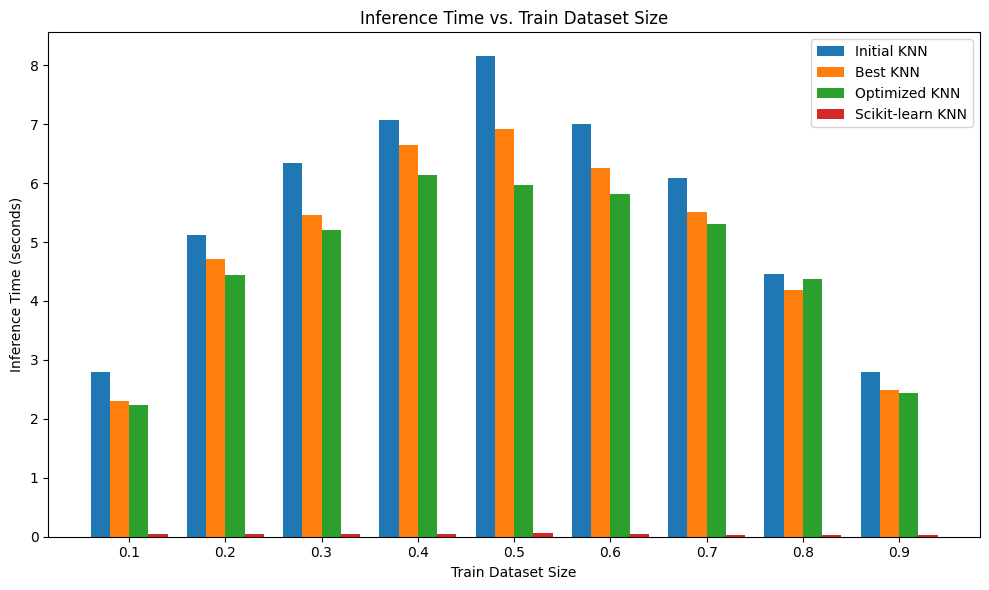

In [27]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Initialize variables to store inference times
inference_times_by_size = []

# KNN configurations to compare
knn_configurations = [
    {'k': 3, 'classifier_type': 'Initial KNN'},
    {'k': 9, 'classifier_type': 'Best KNN'},
    {'k': 3, 'classifier_type': 'Optimized KNN'},
    {'k': 3, 'classifier_type': 'Scikit-learn KNN'}
]

# Define the train sizes you want to test
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for train_size in train_sizes:
    inference_times_for_size = []

    for config in knn_configurations:
        k = config['k']
        classifier_type = config['classifier_type']

        # Load the ResNet embeddings 
        embeddings = np.array([item[1] for item in dataset])
        label_names = np.array([item[3] for item in dataset])

        # Reshape data only for the scikit-learn KNN
        if classifier_type == 'Scikit-learn KNN':
            X_2D = embeddings.reshape(1500, 1024)
        else:
            X_2D = embeddings

        # Split data into training and validation subsets
        X_train, X_val, y_train, y_val = train_test_split(X_2D, label_names, train_size=train_size, random_state=42)

        # Measure inference time for KNN
        start_time = time.time()
        if classifier_type == 'Optimized KNN':
            knn = OptimizedKNNClassifier(k=k, distance_metric='chebyshev', encoding_type='ResNet')
            knn.fit(X_train, y_train)
            _ = knn.prediction(X_val)
        elif classifier_type == 'Initial KNN':
            knn = KNNClassifier(k=k, distance_metric='euclidean', encoding_type='ResNet')
            knn.fit(X_train, y_train)
            _ = knn.prediction(X_val)
        elif classifier_type != 'Scikit-learn KNN':
            knn = KNNClassifier(k=k, distance_metric='manhattan', encoding_type='ResNet')
            knn.fit(X_train, y_train)
            _ = knn.prediction(X_val)
        else:
            knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
            knn.fit(X_train, y_train)
            _ = knn.predict(X_val)
        
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times_for_size.append(inference_time)

    inference_times_by_size.append(inference_times_for_size)

# Convert to numpy array for easy plotting
inference_times_array = np.array(inference_times_by_size)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
positions = np.arange(len(train_sizes))

for i, classifier_name in enumerate(['Initial KNN', 'Best KNN', 'Optimized KNN', 'Scikit-learn KNN']):
    ax.bar(positions + i * bar_width, inference_times_array[:, i], bar_width, label=classifier_name)

ax.set_xlabel('Train Dataset Size')
ax.set_ylabel('Inference Time (seconds)')
ax.set_title('Inference Time vs. Train Dataset Size')
# To ensure that the tick marks are aligned with the center of each group of bars
ax.set_xticks(positions + (len(['Initial KNN', 'Best KNN', 'Optimized KNN', 'Scikit-learn KNN']) - 1) * bar_width / 2)
ax.set_xticklabels(train_sizes)
ax.legend()
plt.tight_layout()
plt.show()


# Decision Trees

### Data visualization and exploration

In [36]:
# Loading the dataset
d_path = '/home/sruj/Downloads/advertisement.csv'
data = pd.read_csv(d_path)

data.head(15)

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home
5,20,Female,51266.767047,Master,True,3,Frankport,Scientist,95.145103,laptop,sports electronics books
6,27,Male,29578.136416,Bachelor,True,3,North Shelbyshire,Lawyer,69.022842,table,beauty furniture clothing
7,20,Female,35325.309005,PhD,False,3,South Raventown,Housewife,110.564517,dictionary,books beauty
8,51,Male,40232.564356,PhD,True,0,Leonardtown,Salesman,107.835490,curtains,electronics food home sports
9,19,Male,48053.583882,PhD,True,0,South Susan,Artist,108.854898,chips,furniture food


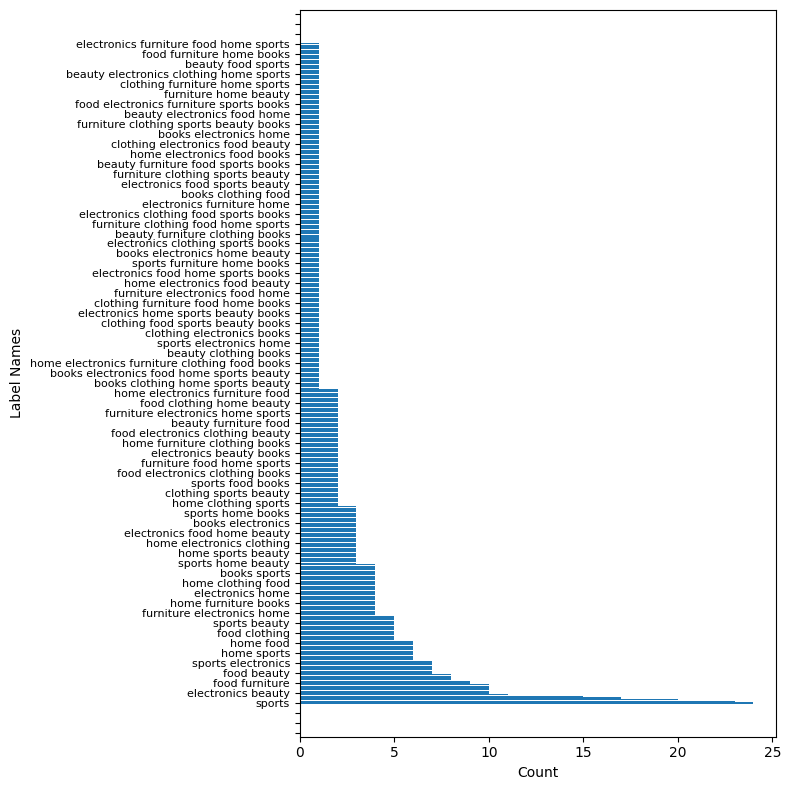

In [37]:
# Visalising the dataset 
# Calculate label distribution
label_count = data['labels'].value_counts()
unique_labels = label_count.index

# Visualize class distribution
plt.figure(figsize=(8, 8))

# Horizontal bar plot
plt.barh(unique_labels, label_count)
plt.xlabel('Count')
plt.ylabel('Label Names')
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=75))
plt.tight_layout()
plt.show()

## MultiLabel Classification
### 3.3.1 Tasks

## Powerset Formulation


### Data Processing and Featurization

In [37]:
data.dtypes

age                   int64
gender               object
income              float64
education            object
married                bool
children              int64
city                 object
occupation           object
purchase_amount     float64
most bought item     object
labels               object
dtype: object

In [41]:
# Encode categorical columns using label encoding
categorical_cols = ['gender', 'education', 'city', 'occupation', 'most bought item']
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Convert the 'labels' column to a list of sets
data['labels'] = data['labels'].apply(lambda x: set(x.split()))

print(data.head())

   age  gender        income  education  married  children  city  occupation  \
0   45       1  61271.953359          2    False         3   366           2   
1   24       0  53229.101074          1    False         1    98           1   
2   45       0  30066.046684          0     True         3   403           3   
3   19       1  48950.246384          3    False         0   959           6   
4   29       0  44792.627094          2    False         0   521           1   

   purchase_amount  most bought item                                 labels  
0        87.697118                16        {sports, electronics, clothing}  
1       115.135586                13                    {furniture, beauty}  
2       101.694559                 3  {electronics, sports, clothing, food}  
3        97.964887                14                                 {food}  
4        86.847281                 4                                 {home}  


### Train val test splitting

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

X = data.drop(columns=['labels'])

# --GPT--
# Binarize the labels using MultiLabelBinarizer
#  MultiLabelBinarizer converts input labels into multilabel labels, each example can belong to multiple classes.
mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(data['labels'])

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binarized, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the resulting sets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (700, 10) (700, 8)
Validation set: (150, 10) (150, 8)
Test set: (150, 10) (150, 8)


### Decision Tree Classifier Class with the Powerset Formulation

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class PowersetDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth # maximum depth of the decision tree
        self.max_features = max_features # maximum number of features considered when deciding how to split a node
        self.criterion = criterion # impurity measure used to split nodes
        self.classifiers = {}  # Dictionary to store individual classifiers, where each classifier corresponds to a unique label combinations in a powerset classification

    #--GPT--
    def fit(self, X_train, y_train):
        for label in range(y_train.shape[1]):
            classifier = DecisionTreeClassifier(max_depth=self.max_depth,max_features=self.max_features,criterion=self.criterion)
            classifier.fit(X_train, y_train[:, label])
            self.classifiers[label] = classifier # store the classifier for each label
            
    def predict(self, X):
        predictions = []
        for label in self.classifiers:
            predictions.append(self.classifiers[label].predict(X))
        # align the predictions with the input instances
        return pd.DataFrame(predictions).T.values

# Initialize and use the PowersetDecisionTreeClassifier class
powerset_clf = PowersetDecisionTreeClassifier(max_depth=None, max_features=None, criterion='gini')
powerset_clf.fit(X_train, y_train)

y_val_pred_powerset = powerset_clf.predict(X_val)
y_test_pred_powerset = powerset_clf.predict(X_test)

# Calculate accuracy for validation set
accuracy_val = accuracy_score(y_val, y_val_pred_powerset)
print("Accuracy on Validation Set:", accuracy_val)

# # Calculate accuracy for test set
# accuracy_test = accuracy_score(y_test, y_test_pred_powerset)
# print("Accuracy on Test Set:", accuracy_test)

Accuracy on Validation Set: 0.02666666666666667


## MultiOutput Formulation

### Data Processing and featurization

In [38]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Drop rows with missing values
data.dropna(inplace=True)  

# one-hot encoding to encode categorical features 
categorical_cols = ['gender', 'education', 'married', 'city', 'occupation']
onehot_encoder = OneHotEncoder(sparse=False, drop="first")
encoded_categorical = onehot_encoder.fit_transform(data[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out(input_features=categorical_cols))

# Convert text feature to numerical using CountVectorizer
text_vectorizer = CountVectorizer()
X_text = text_vectorizer.fit_transform(data['most bought item'])
X_text_df = pd.DataFrame(X_text.toarray(), columns=text_vectorizer.get_feature_names_out(input_features=['most bought item']))

# Combine numerical features, encoded categorical features, and text features
processed_data = pd.concat([data.drop(columns=categorical_cols + ['most bought item']), encoded_categorical_df, X_text_df], axis=1)

# Label encoding for labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data["labels"])

# Convert encoded labels to a DataFrame
encoded_labels_data = pd.DataFrame({"encoded_labels": encoded_labels})

# Concatenate the processed input features and encoded labels
final_processed_data = pd.concat([processed_data, encoded_labels_data], axis=1)
final_processed_data = final_processed_data.drop(columns=['labels'])

# Display the processed input features
print("Processed Input Features:")
print(final_processed_data.head())

Processed Input Features:
   age        income  children  purchase_amount  gender_Male  \
0   45  61271.953359         3        87.697118          1.0   
1   24  53229.101074         1       115.135586          0.0   
2   45  30066.046684         3       101.694559          0.0   
3   19  48950.246384         0        97.964887          1.0   
4   29  44792.627094         0        86.847281          0.0   

   education_High School  education_Master  education_PhD  married_True  \
0                    0.0               1.0            0.0           0.0   
1                    1.0               0.0            0.0           0.0   
2                    0.0               0.0            0.0           1.0   
3                    0.0               0.0            1.0           0.0   
4                    0.0               1.0            0.0           0.0   

   city_Abigailshire  ...  mobile  monitor  novel  pants  perfume  shirt  \
0                0.0  ...       0        1      0      0      

/home/sruj/jupyter/environment/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Train val test splitting

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Extract features and labels
X = final_processed_data.drop(columns=['encoded_labels'])
y = final_processed_data['encoded_labels']

# Convert labels to a list of sets
label_sets = [set([label]) for label in encoded_labels]

# Initialize and fit the MultiLabelBinarizer on label sets
mlb = MultiLabelBinarizer()
y_multioutput = mlb.fit_transform(label_sets)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_multioutput, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (700, 1011) (700, 397)
Validation set: (150, 1011) (150, 397)
Test set: (150, 1011) (150, 397)


### Decision Tree Classifier Class with the MultiOutput Formulation

In [40]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the base classifier for the MultiOutput Formulation
# random_state is set to 42 for reproducibility - used to control the randomness initialization in ML algorithms
base_classifier_multioutput = DecisionTreeClassifier(max_depth=5, max_features=10, criterion='gini', random_state=42)

# Initialize the MultiOutputClassifier
# n_jobs=-1 to use all available CPU cores for parallel processing
multioutput_clf = MultiOutputClassifier(base_classifier_multioutput, n_jobs=-1)

multioutput_clf.fit(X_train, y_train)
y_val_pred_multioutput = multioutput_clf.predict(X_val)

# Calculate accuracy for each class label
accuracies = []
for class_label in range(y_val.shape[1]):
    y_val_class = y_val[:, class_label]  # True labels for the class
    y_val_pred_class = y_val_pred_multioutput[:, class_label]  # Predicted labels for the class
    accuracy_class = accuracy_score(y_val_class, y_val_pred_class)
    accuracies.append(accuracy_class)

# Average accuracy
average_accuracy = np.mean(accuracies)
print("MultiOutput Formulation Validation Average Accuracy:", average_accuracy)


MultiOutput Formulation Validation Average Accuracy: 0.9974811083123426


## Hyperparamter Tuning

### 1. Report the Metrics (Accuracy, F1(micro and macro) , Confusion Matrix, Precision , Recall) for all possible triplet of hyperparamters for both Powerset and MultiOutput Setting.

In [46]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Define the possible hyperparameters
criterions = ['gini', 'entropy']
max_depths = [3, 5, 10, 20, 30]
max_features = [3, 5, 7, 9, 11]

# Initialize lists to store the results
powerset_results = []
multioutput_results = []

def round_metrics(metrics, decimal_places=4):
    return [round(metric, decimal_places) for metric in metrics]

# Iterate through all possible hyperparameter combinations
for criterion in criterions:
    for max_depth in max_depths:
        for max_feature in max_features:
            
            # PowersetDecisionTreeClassifier 
            powerset_clf = PowersetDecisionTreeClassifier(max_depth=max_depth, max_features=max_feature, criterion=criterion)
            powerset_clf.fit(X_train, y_train)
            y_val_pred_powerset = powerset_clf.predict(X_val)
            
            # MultiOutputClassifier 
            multioutput_clf = MultiOutputClassifier(DecisionTreeClassifier(max_depth=max_depth, max_features=max_feature, criterion=criterion))
            multioutput_clf.fit(X_train, y_train)
            y_val_pred_multioutput = multioutput_clf.predict(X_val)

            # --GPT--
            # Calculate metrics for Powerset 
            accuracy_powerset = accuracy_score(y_val, y_val_pred_powerset)
            f1_micro_powerset = f1_score(y_val, y_val_pred_powerset, average='micro')
            f1_macro_powerset = f1_score(y_val, y_val_pred_powerset, average='macro')
            precision_powerset = precision_score(y_val, y_val_pred_powerset, average='micro')
            recall_powerset = recall_score(y_val, y_val_pred_powerset, average='micro')

            # Round the metrics to 4 decimal places
            rounded_metrics_powerset = round_metrics([accuracy_powerset, f1_micro_powerset, f1_macro_powerset, precision_powerset, recall_powerset])

            # Calculate metrics for MultiOutput 
            accuracy_multioutput = accuracy_score(y_val, y_val_pred_multioutput)
            f1_micro_multioutput = f1_score(y_val, y_val_pred_multioutput, average='micro')
            f1_macro_multioutput = f1_score(y_val, y_val_pred_multioutput, average='macro')
            precision_multioutput = precision_score(y_val, y_val_pred_multioutput, average='micro')
            recall_multioutput = recall_score(y_val, y_val_pred_multioutput, average='micro')
            
            # Round the metrics to 4 decimal places
            rounded_metrics_multioutput = round_metrics([accuracy_multioutput, f1_micro_multioutput, f1_macro_multioutput, precision_multioutput, recall_multioutput])

            # Store the results
            powerset_results.append([criterion, max_depth, max_feature, *rounded_metrics_powerset])
            multioutput_results.append([criterion, max_depth, max_feature, *rounded_metrics_multioutput])
            
# Create headers for the table
headers = ['Criterion', 'Max Depth', 'Max Features', 'Accuracy', 'F1 Micro', 'F1 Macro', 'Precision', 'Recall']

# Print the table for Powerset results
print("Powerset Results:")
print(tabulate(powerset_results, headers=headers, tablefmt='pretty'))

# Print the table for MultiOutput results
print("\nMultiOutput Results:")
print(tabulate(multioutput_results, headers=headers, tablefmt='pretty'))


Powerset Results:
+-----------+-----------+--------------+----------+----------+----------+-----------+--------+
| Criterion | Max Depth | Max Features | Accuracy | F1 Micro | F1 Macro | Precision | Recall |
+-----------+-----------+--------------+----------+----------+----------+-----------+--------+
|   gini    |     3     |      3       |  0.0533  |  0.2669  |  0.2459  |  0.7159   | 0.1641 |
|   gini    |     3     |      5       |   0.08   |  0.3116  |  0.2782  |  0.8132   | 0.1927 |
|   gini    |     3     |      7       |   0.1    |  0.3984  |  0.381   |  0.8475   | 0.2604 |
|   gini    |     3     |      9       |  0.1067  |  0.425   |  0.3994  |   0.845   | 0.2839 |
|   gini    |     3     |      11      |  0.1133  |  0.4348  |  0.4146  |  0.9016   | 0.2865 |
|   gini    |     5     |      3       |  0.0533  |  0.2772  |  0.2638  |  0.4933   | 0.1927 |
|   gini    |     5     |      5       |  0.0667  |  0.3765  |  0.3496  |   0.559   | 0.2839 |
|   gini    |     5     |      7

### 2. For both of them also rank the top 3 performing set of hyperparamters according to F1 Score.

In [47]:
def get_top_results(results, score_column_index, top_count):
    sorted_results = results[results[:, score_column_index].argsort()[::-1]]
    top_results = sorted_results[:top_count]
    return top_results

powerset_results = np.array(powerset_results)
multioutput_results = np.array(multioutput_results)

top_count = 3
f1_macro_column_index = 5
f1_micro_column_index = 4

top_powerset_macro = get_top_results(powerset_results, f1_macro_column_index, top_count)
top_multioutput_macro = get_top_results(multioutput_results, f1_macro_column_index, top_count)
top_powerset_micro = get_top_results(powerset_results, f1_micro_column_index, top_count)
top_multioutput_micro = get_top_results(multioutput_results, f1_micro_column_index, top_count)

# --GPT--
headers = ['Criterion', 'Max Depth', 'Max Features', 'Accuracy', 'F1 Micro', 'F1 Macro', 'Precision', 'Recall']

# Print the top performing sets of hyperparameters for Powerset setting based on F1 Macro score
print("Top Performing Sets of Hyperparameters for Powerset Setting (F1 Macro):")
print(tabulate(top_powerset_macro, headers=headers, tablefmt='pretty'))

# Print the top performing sets of hyperparameters for MultiOutput setting based on F1 Macro score
print("\nTop Performing Sets of Hyperparameters for MultiOutput Setting (F1 Macro):")
print(tabulate(top_multioutput_macro, headers=headers, tablefmt='pretty'))

# Print the top performing sets of hyperparameters for Powerset setting based on F1 Micro score
print("\nTop Performing Sets of Hyperparameters for Powerset Setting (F1 Micro):")
print(tabulate(top_powerset_micro, headers=headers, tablefmt='pretty'))

# Print the top performing sets of hyperparameters for MultiOutput setting based on F1 Micro score
print("\nTop Performing Sets of Hyperparameters for MultiOutput Setting (F1 Micro):")
print(tabulate(top_multioutput_micro, headers=headers, tablefmt='pretty'))


Top Performing Sets of Hyperparameters for Powerset Setting (F1 Macro):
+-----------+-----------+--------------+----------+----------+----------+-----------+--------+
| Criterion | Max Depth | Max Features | Accuracy | F1 Micro | F1 Macro | Precision | Recall |
+-----------+-----------+--------------+----------+----------+----------+-----------+--------+
|  entropy  |    30     |      9       |  0.0267  |  0.5235  |  0.5214  |  0.4977   | 0.5521 |
|  entropy  |    10     |      9       |  0.0667  |  0.514   |  0.5099  |  0.5579   | 0.4766 |
|  entropy  |    10     |      7       |   0.04   |  0.5158  |  0.5073  |  0.5213   | 0.5104 |
+-----------+-----------+--------------+----------+----------+----------+-----------+--------+

Top Performing Sets of Hyperparameters for MultiOutput Setting (F1 Macro):
+-----------+-----------+--------------+----------+----------+----------+-----------+--------+
| Criterion | Max Depth | Max Features | Accuracy | F1 Micro | F1 Macro | Precision | Recall

### 3. For the best performing model for each approach report the K Fold validation metrics for an appropriate choice of K

In [49]:
from sklearn.model_selection import KFold

def initialize_classifiers():
    best_powerset_hp_macro = top_powerset_macro[0, 0:3]
    best_multioutput_hp_macro = top_multioutput_macro[0, 0:3]
    best_powerset_hp_micro = top_powerset_micro[0, 0:3]
    best_multioutput_hp_micro = top_multioutput_micro[0, 0:3]

    # Initializing classifiers using the hyperparameters
    best_powerset_clf_macro = PowersetDecisionTreeClassifier(criterion=best_powerset_hp_macro[0],
                                                             max_depth=int(best_powerset_hp_macro[1]),
                                                             max_features=int(best_powerset_hp_macro[2]))
    
    best_multioutput_clf_macro = MultiOutputClassifier(DecisionTreeClassifier(criterion=best_multioutput_hp_macro[0],
                                                                               max_depth=int(best_multioutput_hp_macro[1]),
                                                                               max_features=int(best_multioutput_hp_macro[2])))
    
    best_powerset_clf_micro = PowersetDecisionTreeClassifier(criterion=best_powerset_hp_micro[0],
                                                             max_depth=int(best_powerset_hp_micro[1]),
                                                             max_features=int(best_powerset_hp_micro[2]))
    
    best_multioutput_clf_micro = MultiOutputClassifier(DecisionTreeClassifier(criterion=best_multioutput_hp_micro[0],
                                                                               max_depth=int(best_multioutput_hp_micro[1]),
                                                                               max_features=int(best_multioutput_hp_micro[2])))
    
    return best_powerset_clf_macro, best_multioutput_clf_macro, best_powerset_clf_micro, best_multioutput_clf_micro

# The value of k is set to 5
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing the classifiers using the best hyperparameters
(best_powerset_clf_macro, best_multioutput_clf_macro,
 best_powerset_clf_micro, best_multioutput_clf_micro) = initialize_classifiers()

# Lists to store cross-validation results
powerset_macro_f1_scores = []
multioutput_macro_f1_scores = []
powerset_micro_f1_scores = []
multioutput_micro_f1_scores = []

# k-fold cross-validation
for train_index, val_index in k_fold.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Fit and predict using the classifiers
    best_powerset_clf_macro.fit(X_train_fold, y_train_fold)
    y_val_pred_powerset_macro = best_powerset_clf_macro.predict(X_val_fold)
    
    best_multioutput_clf_macro.fit(X_train_fold, y_train_fold)
    y_val_pred_multioutput_macro = best_multioutput_clf_macro.predict(X_val_fold)
    
    best_powerset_clf_micro.fit(X_train_fold, y_train_fold)
    y_val_pred_powerset_micro = best_powerset_clf_micro.predict(X_val_fold)
    
    best_multioutput_clf_micro.fit(X_train_fold, y_train_fold)
    y_val_pred_multioutput_micro = best_multioutput_clf_micro.predict(X_val_fold)

    # --GPT--
    # Calculate F1 Macro scores and store them
    powerset_macro_f1_scores.append(f1_score(y_val_fold, y_val_pred_powerset_macro, average='macro'))
    multioutput_macro_f1_scores.append(f1_score(y_val_fold, y_val_pred_multioutput_macro, average='macro'))
    
    # Calculate F1 Micro scores and store them
    powerset_micro_f1_scores.append(f1_score(y_val_fold, y_val_pred_powerset_micro, average='micro'))
    multioutput_micro_f1_scores.append(f1_score(y_val_fold, y_val_pred_multioutput_micro, average='micro'))


# Calculate the average and standard deviation of F1 scores
avg_powerset_macro_f1 = np.mean(powerset_macro_f1_scores)
std_powerset_macro_f1 = np.std(powerset_macro_f1_scores)

avg_multioutput_macro_f1 = np.mean(multioutput_macro_f1_scores)
std_multioutput_macro_f1 = np.std(multioutput_macro_f1_scores)

avg_powerset_micro_f1 = np.mean(powerset_micro_f1_scores)
std_powerset_micro_f1 = np.std(powerset_micro_f1_scores)

avg_multioutput_micro_f1 = np.mean(multioutput_micro_f1_scores)
std_multioutput_micro_f1 = np.std(multioutput_micro_f1_scores)

# Print the k-fold cross-validation results
print("Powerset Formulation Cross-Validation F1 macro scores:")
print("Average:", avg_powerset_macro_f1)
print("Standard Deviation:", std_powerset_macro_f1)

print("\nMultiOutput Formulation Cross-Validation F1 macro scores:")
print("Average:", avg_multioutput_macro_f1)
print("Standard Deviation:", std_multioutput_macro_f1)

print("\nPowerset Formulation Cross-Validation F1 micro scores:")
print("Average:", avg_powerset_micro_f1)
print("Standard Deviation:", std_powerset_micro_f1)

print("\nMultiOutput Formulation Cross-Validation F1 micro scores:")
print("Average:", avg_multioutput_micro_f1)
print("Standard Deviation:", std_multioutput_micro_f1)


Powerset Formulation Cross-Validation F1 macro scores:
Average: 0.48315662180910407
Standard Deviation: 0.015200241807578164

MultiOutput Formulation Cross-Validation F1 macro scores:
Average: 0.45889495688116577
Standard Deviation: 0.021348226830549027

Powerset Formulation Cross-Validation F1 micro scores:
Average: 0.49374160079301593
Standard Deviation: 0.02385591394151641

MultiOutput Formulation Cross-Validation F1 micro scores:
Average: 0.45921737524812717
Standard Deviation: 0.0130156562076572
